In [1]:
# pip install pyramid.arima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import timedelta
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from statsmodels.tsa.holtwinters import Holt
from pmdarima.arima import auto_arima

In [3]:
# Own Function
def movie_select(movie_name, df, attribute):
    movie_name = movie_name
    movies = df[df['replace'] == movie_name]
    movies.index = movies['days']
    movie = movies[[attribute]]
    return(movie)


def movie_calc(df, days, exponential, smoothing_level, smoothing_slope):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    
    
    # Plot
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(y_hat['arima'], label = 'Arima')
    plt.plot(y_hat['holt'], label = 'Holt')
    plt.plot(y_hat['naive'], label = 'Naive')
    plt.legend()
    plt.show

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    x = x.sort_values(by=['RMSE'])
    
    return(x)

### 1. Load Data & Preprocessing

In [4]:
brand = pd.read_csv('../data_concat/movies.csv')

In [5]:
fb_1k = pd.read_table('../data/view_brand_rollup_facebook_1k-10k.tsv')
fb_10k = pd.read_table('../data/view_brand_rollup_facebook_10kplus.tsv')
fb = pd.concat([fb_1k, fb_10k])
fb = pd.merge(fb, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

insta_1k = pd.read_table('../data/view_brand_rollup_instagram_1k-10k.tsv')
insta_10k = pd.read_table('../data/view_brand_rollup_instagram_10kplus.tsv')
insta = pd.concat([insta_1k, insta_10k])
insta = pd.merge(insta, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

twit_1k = pd.read_table('../data/view_brand_rollup_twitter_1k-10k.tsv')
twit_10k = pd.read_table('../data/view_brand_rollup_twitter_10kplus.tsv')
twit = pd.concat([twit_1k, twit_10k])
twit = pd.merge(twit, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

In [6]:
fb['data_for']= pd.to_datetime(fb['data_for']) 
fb['released_on'] = pd.to_datetime(fb['released_on'])
fb['days_after_release'] = fb['data_for'] - fb['released_on'] 
fb = fb[(fb['days_after_release'] <= '0 days') & (fb['days_after_release'] >= '-365 days')]
fb['days'] = fb['days_after_release'] + timedelta(days=365)

insta['data_for']= pd.to_datetime(insta['data_for']) 
insta['released_on'] = pd.to_datetime(insta['released_on'])
insta['days_after_release'] = insta['data_for'] - insta['released_on'] 
insta = insta[(insta['days_after_release'] <= '0 days') & (insta['days_after_release'] >= '-365 days')]
insta['days'] = insta['days_after_release'] + timedelta(days=365)

twit['data_for']= pd.to_datetime(twit['data_for']) 
twit['released_on'] = pd.to_datetime(twit['released_on'])
twit['days_after_release'] = twit['data_for'] - twit['released_on'] 
twit = twit[(twit['days_after_release'] <= '0 days') & (twit['days_after_release'] >= '-365 days')]
twit['days'] = twit['days_after_release'] + timedelta(days=365)

### 2. Selecting Movie / Cluster and Data Column for Prediction

In [7]:
movie_name = 'Divergent'
fb_movies = fb[fb['replace'] == movie_name]
fb_movies.index = fb_movies['days']
fb_movie = fb_movies[['total_post_interactions']]

### 3. Split train/test

<function matplotlib.pyplot.show(*args, **kw)>

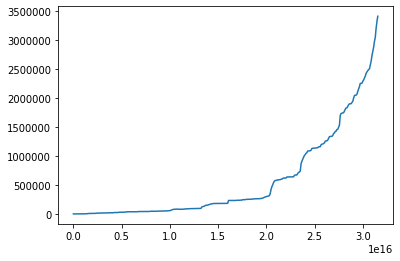

In [8]:
plt.plot(fb_movie)
plt.show

Looking at the plot, 150 days out might give wildly inaccurate forecasts because of the exponential trend appearing much later. At day 250 (~100 days out would be a benchmark) as it would give producers insights on how the trend would look like 3 months out. If it is not desirable, producers can therefore try to change metrics. 

We will try:

__90 days (3 months)__

__60 days (2 months)__ 

__30 days (1 month)__

In [9]:
days = 90
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

<function matplotlib.pyplot.show(*args, **kw)>

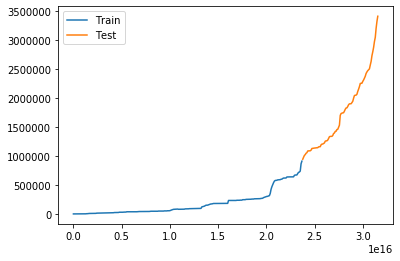

In [10]:
plt.figure()
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.legend(loc='best')
plt.show

### 4. Train Models

We will use different models:

a. Naive (basic model to compare against)

b. Holt's Linear (we will not use holt winters because data does not have seasonal trend)

d. ARIMA 

### 90 Days

#### a. Naive 

In [11]:
dd = np.asarray(train)
dd = np.repeat(dd[-1], len(test))
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

RMSE is:  1034136.87


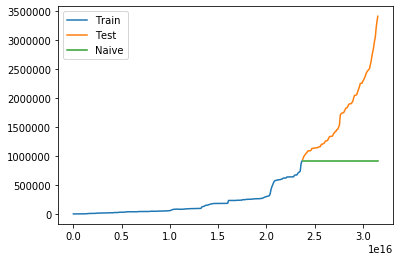

In [12]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat['naive'], label = 'Naive')
plt.legend()
plt.show

rms_naive = sqrt(mse(test, y_hat.naive))
print('RMSE is: ', round(rms_naive,2))

#### b. Holt's Linear
As we see an increasing exponential trend, we will use set exponential parameter as True and tune smoothing_level and smoothing_slope. (To be done later)

In [13]:
exponential = True
smoothing_level = 0.1
smoothing_slope = 0.0005

y_hat_holt= test.copy()

fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
y_hat_holt['holt'] = fit1.forecast(len(test))

RMSE is:  189765.81


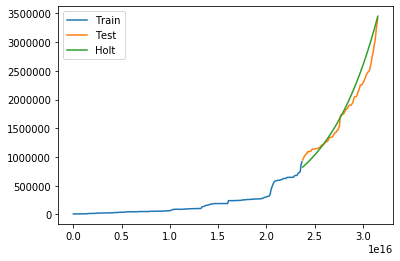

In [14]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_holt['holt'], label = 'Holt')
plt.legend()
plt.show

rms_holt = sqrt(mse(test, y_hat_holt['holt']))
print('RMSE is: ', round(rms_holt,2))

Much more accurate with holt

#### 3. Arima (auto-arima)

In [15]:
model = auto_arima(np.asarray(train), trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

y_hat_arima = test.copy()
forecast = model.predict(n_periods=len(test))
y_hat_arima['arima'] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=5774.107, BIC=5795.764, Time=0.164 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=5848.747, BIC=5855.966, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=5802.483, BIC=5813.312, Time=0.027 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=5780.793, BIC=5791.621, Time=0.032 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=5846.819, BIC=5850.429, Time=0.009 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=5782.336, BIC=5800.384, Time=0.101 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=5778.988, BIC=5797.036, Time=0.096 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=5770.341, BIC=5795.607, Time=0.240 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=5773.751, BIC=5795.408, Time=0.211 seconds
Fit ARIMA(4,2,2)x(0,0,0,0) [intercept=True]; AIC=5777.408, BIC=5806.284, Time=0.670 seconds
Fit ARIMA(3,2,3)x(0,0,0,0) [intercep

RMSE is:  2509122.77


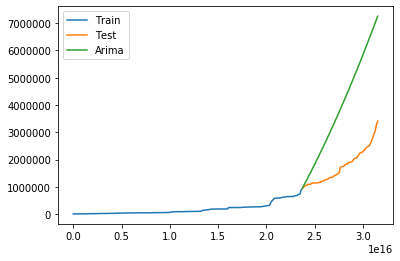

In [18]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_arima['arima'], label = 'Arima')
plt.legend()
plt.show

rms_arima = sqrt(mse(test, y_hat_arima['arima']))
print('RMSE is: ', round(rms_arima,2))

### 60 days

,RMSE
Holt,209234.497194
Arima,547408.272349
Naive,948392.230916


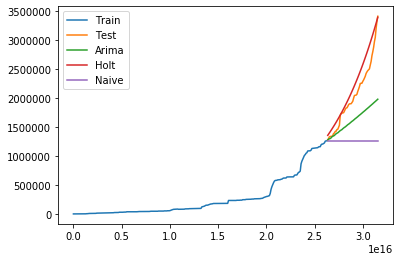

In [19]:
movie_calc(fb_movie, 60, True, 0.1, 0.0005)

### 30 Days

,RMSE
Holt,120584.803669
Arima,345685.206945
Naive,674953.537227


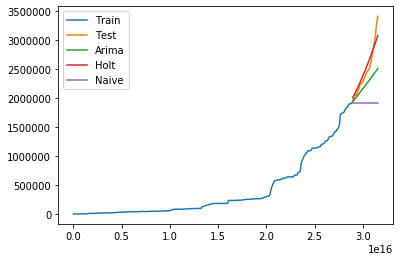

In [195]:
movie_calc(fb_movie, 30, True, 0.1, 0.0005)

Holt generally out performs ARIMA

## Repeat Process for Instagram

In [170]:
insta_movie = movie_select('Divergent', insta, 'total_post_interactions')

<function matplotlib.pyplot.show(*args, **kw)>

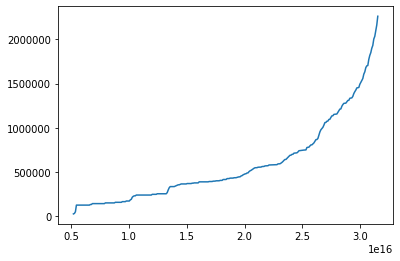

In [171]:
plt.plot(insta_movie)
plt.show

Instagram shows similar trends to Facebook

### 90 days

,RMSE
Holt,370640.028293
Arima,507349.546030
Naive,660899.883548


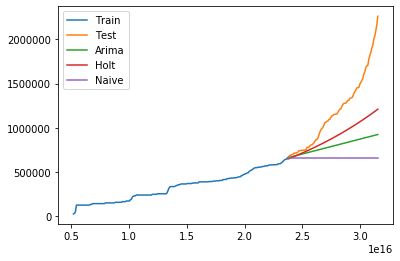

In [181]:
movie_calc(insta_movie, 90, True, 0.1, 0.0005)

### 60 Days

,RMSE
Holt,361999.461021
Arima,496927.702394
Naive,616026.041475


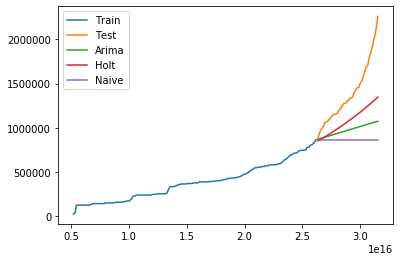

In [182]:
movie_calc(insta_movie, 60, True, 0.1, 0.0005)

### 30 days

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,RMSE
Holt,190580.392833
Arima,221827.775296
Naive,441021.589835


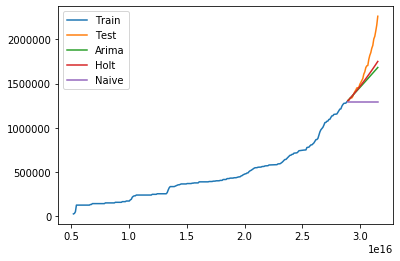

In [196]:
movie_calc(insta_movie, 30, True, 0.1, 0.0005)

## Repeat Process for Twitter

In [184]:
twit_movie = movie_select('Divergent', fb, 'total_post_interactions')

### 90 Days

,RMSE
Holt,1.897658e+05
Naive,1.034137e+06
Arima,2.509123e+06


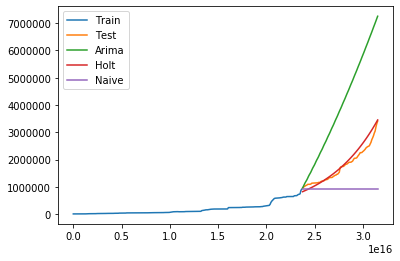

In [185]:
movie_calc(twit_movie, 90, True, 0.1, 0.0005)

### 60 Days

,RMSE
Holt,209234.497194
Arima,547408.272349
Naive,948392.230916


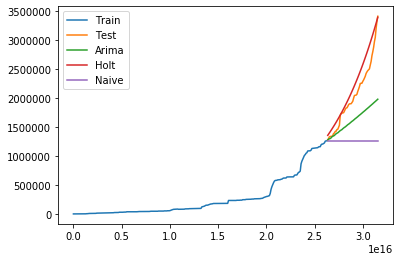

In [186]:
movie_calc(twit_movie, 60, True, 0.1, 0.0005)

### 30 Days

,RMSE
Holt,120584.803669
Arima,345685.206945
Naive,674953.537227


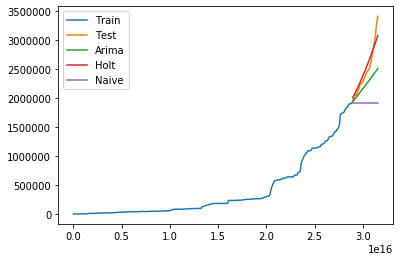

In [187]:
movie_calc(twit_movie, 30, True, 0.1, 0.0005)